# 설정

In [159]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Evaluation Indicator"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(IMAGES_PATH, format=fig_extension, dpi=resolution)

# 평가

지금까지 분류 성능 평가에 정확도(정확하게 분류된 샘플이 비율)를 사용했고, 회귀 성능 평가에는 $R^2$을 사용했다. 그러나 주어진 데이터셋에 대한 지도 학습 모델의 성능을 재는 방법은 그 외에도 많다. 실전에서 애플리케이션에 따라 이런 평가 지표가 적합하지 않을 수 있으므로, 모델을 선택하고 매개변수를 튜닝할 때 올바른 지표를 선택하는 것이 중요하다.

## 최종 목표를 기억하라

평가 지표를 선택할 때 머신러닝 애플리케이션의 최종 목표를 기억해야 한다. 실제로 정확한 예측을 만드는 것뿐 아니라 큰 의사 결정 프로세스의 일부로 사용하는 데 더 중점을 둬야 할지 모른다. 머신러닝 평가 지표를 선택하기 전에 비지니스 지표라고 부르는 애플리케이션의 고차원적인 목표를 생각해야 한다. 어떤 머신러닝 애플리케이션에서 특정 알고리즘을 선택하여 나타난 결과를 <b>비지니스 임팩트</b><sup>business impact</sup>라고 한다. 고차원적인 목표는 교통사고를 피하거나 입원 환자 수를 줄이는 것일지 모른다. 또는 웹사이트에 더 많은 사용자를 유입시키거나 쇼핑몰에서 사용자의 소비를 늘리는 것일 수 있다. 모델을 선택하고 매개변수를 조정할 때, 이런 비지니스 지표에 긍정적인 영향을 주는 모델과 매개변수를 선택해야 한다. 많은 경우에 특정 모델이 비지니스에 미치는 영향은 실제 운영 시스템에 적용해야 알 수 있기 때문에 어려운 문제다.

개발 초기 단계에서 매개변수를 조정하기 위해 시험 삼아 모델을 운영 시스템에 곧바로 적용하기란 비지니스적으로나 개인적으로나 위험부담이 커서 현실적으로 불가능하다. 자율 주행 자동차의 보행자 회피 기능을 먼저 검증하지 않고 실전에 투입하여 평가한다고 생각해보자. 모델이 나쁘다면 보행자가 위험에 처하게 된다. 그래서 계산하기 쉬운 평가 지표를 이용한 대리 평가 방식을 종종 사용한다. 예를 들면 보행자와 보행자가 아닌 이미지를 분류하는 테스트를 수행해서 정확도를 측정할 수 있다. 이는 대체 방식이므로 평가가 가능하고 원래 비지니스 목적에 가장 가까운 지표를 찾아야 한다. 이 근사 지표는 모델을 평가할 때나 선택할 때마다 사용해야 한다. 평가의 결과는 하나의 숫자가 아닐 수 있지만, 선택한 모델의 예상 비지니스 임팩트를 나타내야 한다. 예를 들어 어떤 알고리즘을 적용하면 고객 수는 10% 늘지만 고객당 매출은 15% 줄어들 수 있다.

이번 절에서는 이진 분류의 특별한 사례에 대한 평가 지표를 먼저 이야기하고, 그다음으로 다중 분류를, 마지막으로 회귀에 대해 설명하겠다.

## 고려할 점

이진 분류는 실전에서 가장 널리 사용하고 개념도 쉬운 머신러닝 알고리즘이다. 하지만 이 간단한 작업을 평가하는 데에도 주의할 점이 많다. 여러 평가 지표를 들여다보기 전에, 정확도를 잘못 측정하는 경우에 대해 살펴보겠다. 이진 분류에는 양성 클래스와 음성 클래스가 있으며 양성 클래스가 우리의 관심 클래스다.

### 에러의 종류

잘못 분류한 샘플의 수가 원하는 정보의 전부는 아니므로, 정확도만으로 예측 성능을 측정하기에는 부족할 때가 종종 있다. 자동화 테스트로 암을 조기 발견하는 애플리케이션을 가정해보겠다. 테스트가 음성이면 건강하다는 뜻이다. 반대로 양성이면 추가 검사를 받아야 한다. 여기서 양성 테스트(암 진단)를 양성 클래스라고 하고 음성 테스트를 음성 클래스라고 한다. 모델이 항상 완벽하게 작동하는 것은 아니니, 잘못 분류할 때가 있다. 어떤 애플리케이션에서든 이런 분류 오류가 실제 현실에서 어떤 결과를 초래하는지 살펴봐야 한다.

예컨대 건강한 사람을 양성으로 분류하면 추가 검사를 받게 할 것이다. 이는 환자에게 비용 손실과 불편함을 가져다준다(그리고 약간의 스트레스도). 이와 같은 잘못된 양성 예측을 <b>거짓 양성</b><sup>false positive</sup>이라 한다. 반대로 암에 걸린 사람을 음성으로 분류하여 제대로 된 검사나 치료를 받지 못하게 할 때도 있다. 암을 발견하지 못하면 건강에 심각한 위협을 가하며 치명적일 수 있다. 이런 종류의 잘못된 음성 예측 오류를 <b>거짓 음성</b><sup>false negative</sup>이라 한다. 통계학에서는 거짓 양성을 타입Ⅰ에러, 거짓 음성을 타입Ⅱ에러라고도 한다. 암 진단 예에서는 거짓 음성을 최대한 피해야 하는 반면, 거짓 양성은 비교적 중요도가 낮다.

이 예는 특히 극단적이지만 일반적으로도 거짓 양성의 중요도와 거짓 음성의 중요도가 비슷한 경우는 매우 드물다. 상업적인 애플리케이션에서는 두 오류를 비용으로 환산하여, 예측 오류로 인한 금전적 손해를 측정한 값을 정확도 대신 사용하기도 한다. 이런 방식이 어떤 모델을 사용할지 비지니스 관점에서 판단하는 데 더 도움이 될 수 있다.

### 불균형 데이터셋

이 두 종류의 에러(거짓 양성과 거짓 음성)는 두 클래스 중 하나가 다른 것보다 훨씬 많을 때 더 중요하다. 실제로 이는 매우 흔한 상황이며, 좋은 예로는 어떤 아이템이 사용자에게 보여진 노출<sup>impression</sup> 데이터로 클릭을 예측하는 것이다. 아이템은 광고일 수도 있고, 관련 기사나 소셜 미디어 사이트에서 팔로우를 위해 추천하는 사람일 수도 있다. 목표는 특정 상품을 보여주면 사용자가 클릭을 할지(즉 관심 대상인지)를 예측하는 것이다. 인터넷에서 볼 수 있는 정보 대부분은 (특히 광고는) 클릭까지 이어지지 않는다. 그래서 사용자가 관심 있는 것을 클릭할 때까지 100개의 공고나 글을 보여줘야 할 수도 있다. 이때 클릭이 아닌 데이터 99개와 클릭 데이터 1개가 데이터셋으로 만들어진다. 다르게 말하면 샘플의 99%가 '클릭 아님'클래스에 속한다. 이렇게 한 클래스가 다른 것보다 훨씬 많은 데이터셋을 <b>불균형 데이터셋</b><sup>imbalanced datasets</sup> 또는 불균형 클래스의 데이터셋이라 한다. 현실에서는 불균형 데이터가 훨씬 많으며, 관심 대상인 이벤트의 빈도가 그렇지 않은 이벤트와 같거나 비슷한 경우는 드물다.

클릭을 99% 정확도로 예측하는 분류기를 만들었다고 해보자. 이는 무슨 뜻일까? 99% 정확도는 꽤 높아 보이지만 이는 불균형 클래스를 고려하지 못했다. 굳이 머신러닝 모델을 만들지 않고서도 무조건 '클릭 아님'으로 예측하면 그 정확도는 99%다. 하지만 불균형 데이터에서도 99% 정확도는 사실 매우 좋은 성능일 수 있다. 그래서 정확도로는 '무조건 클릭 아님' 모델과 '진짜 좋은 모델'을 구분하기 어렵다.

예를 위해서 digits 데이터셋을 사용해 숫자 5를 다른 숫자와 구분해서 9:1의 불균형한 데이터셋을 만들겠다.<sup><a id="a01" href="#p01">[1]</a></sup>

In [65]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [123]:
X, y = mnist["data"].values, mnist["target"].values.astype(np.uint8)
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


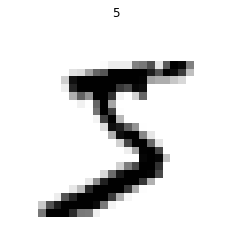

In [126]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.title(y[0])
plt.show()

In [127]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [128]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [129]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

항상 다수인 클래스(여기서는 '5 아님')를 예측값으로 내놓는 DummyClassifier를 사용해서 정확도를 계산해보겠다.<sup><a id="a02" href="#p02">[2]</a></sup>

여기서 <code>cross_val_predict()</code> 함수는 k-겹 교차 검증을 수행하지만 <code>cross_val_score()</code> 함수처럼 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환한다. 즉, 훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻게 된다(여기서 깨끗하다는 뜻은 모델이 훈련하는 동안 보지 못했던 데이터에 대해 예측했다는 의미다).

In [130]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_predict
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train_5)
pred_most_frequent = cross_val_predict(dummy_majority, X_train, y_train_5, cv=3)
print("예측된 레이블의 레이블:", np.unique(pred_most_frequent))
print("테스트 점수: {:.2f}".format(dummy_majority.score(X_test, y_test_5)))

예측된 레이블의 레이블: [False]
테스트 점수: 0.91


거의 아무것도 학습하지 않고 90% 정확도를 얻었다. 누군가 자기 모델의 정확도가 90%라고 말하면 그 사람이 큰일을 해냈다고 생각할 수 있다. 하지만 문제에 따라서는 그저 무조건 한 클래스를 예측하기만 해도 될 수 있다. 실제 분류기를 사용한 것과 비교해보겠다.

In [131]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train_5)
pred_tree = cross_val_predict(tree, X_train, y_train_5, cv=3)
print("테스트 점수: {:.2f}".format(tree.score(X_test, y_test_5)))

테스트 점수: 0.93


정확도로 보면 DecisionTreeClassifier가 더미 분류기보다 조금 나을 뿐이다. 이는 DecisionTreeClassifier를 잘못 사용했거나 이 문제에서는 정확도가 높은 측정 방법이 아님을 말해준다.

비교를 위해 LogisticRegression과 기본 DummyClassifier 분류기 두 개를 더 살펴보겠다. DummyClassifier는 무작위로 선택하므로 훈련 세트와 같은 비율의 예측값을 만든다.<sup><a id="a03" href="#p03">[3]</a></sup>

In [132]:
from sklearn.linear_model import LogisticRegression

dummy = DummyClassifier(strategy='stratified').fit(X_train, y_train_5)
pred_dummy = cross_val_predict(dummy, X_train, y_train_5, cv=3)
print("dummy 점수: {:.2f}".format(dummy.score(X_test, y_test_5)))

pred_sgd = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
print("sgd 점수: {:.2f}".format(sgd_clf.score(X_test, y_test_5)))

dummy 점수: 0.83
sgd 점수: 0.95


무작위로 예측하는 더미 분류기는 (정확도로 봐서는) 확실히 결과가 안 좋다. 반면에 SGD 모델은 매우 좋다. 하지만 더미 분류기조차도 80%를 맞췄다. 이런 결과가 실제로 유용한 것인지 판단하기가 매우 어렵다. 불균형 데이터셋에서 예측 성능을 정량화하는 데 정확도는 적절한 측정 방법이 아니기 때문이다. 이 장의 나머지에서는 모델 선택을 도와주는 다른 평가 지표를 살펴보겠다. 특히 pred_most_frequent와 pred_dummy처럼, 빈도나 무작위 기반 예측보다 얼마나 더 나은지 알려주는 평가 지표가 필요하다. 모델을 평가하는 지표라면 이런 비상식적인 예측은 피할 수 있어야 한다.

## 오차 행렬

이진 분류에서 성능 지표로 잘 활용되는 <b>오차행렬</b><sup>confusion matrix</sup>은 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고<sup>confused</sup> 있는지도 함께 보여주는 지표다. 즉, 이진 분류의 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 나타내는 지표다.

오차 행렬은 다음과 같은 4분면 행렬에서 실제 레이블 클래스 값과 예측 레이블 클래스 값이 어떠한 유형을 가지고 매핑되는지를 나타낸다. 4분면의 왼쪽, 오른쪽을 예측된 클래스 값 기준으로 Negative와 Positive로 분류하고, 4분면의 위, 아래를 실제 클래스 값 기준으로 Negative와 Positive로 분류하면 예측 클래스와 실제 클래스의 값 유형에 따라 결전되는 TN, FP, FN, TP 형태로 오차 행렬의 4분면을 채울 수 있다. TN, FP, FN, TP 값을 다양하게 결합해 분류 모델 예측 성능의 오류가 어떠한 모습으로 발생하는지 알 수 있는 것이다.

<b>그림 1</b> 오차 행렬
<div style="text-align:center;">
    <img src="./images/Evaluation Indicator/오차 행렬.png">
</div>

TN, FP, FN, TP는 예측 클래스와 실제 클래스의 Positive 결정 값(값 1)과 Negative 결정 값(값 0)의 결합에 따라 결정된다. 예를 들어 TN은 True Negative의 의미이며 앞 True는 예측 클래스 값과 실제 클래스 값이 같다는 의미고 뒤의 Negative는 예측값이 Negative 값이라는 의미다. 즉, TN은 예측을 Negative 값 0으로 예측했는데, 실제 값도 Negative 값 0이라는 의미다. TN, FP, FN, TP 기호가 의미하는 것은 앞 문자 True/False는 예측값과 실제값이 '같은가/틀린가'를 의미한다. 뒤 문자 Negative/Positive는 예측 결과 값이 부정(0)/긍정(1)을 의미한다.

<ul>
    <li>TN은 예측값을 Negative 값 0으로 예측했고 실제 값 역시 Negative 값 0</li>
    <li>FP는 예측값을 Positive 값 1로 예측했는데 실제 값은 Negative 값 0</li>
    <li>FN은 예측값을 Negative 값 0으로 예측했는데 실제 값은 Positive 값 1</li>
    <li>TP는 예측값을 Positive 값 1로 예측했는데 실제 값 역시 Positive 값 1</li>
</ul>

사이킷런은 오차 행렬을 구하기 위해 <code>confusion_matrix()</code> API를 제공한다. 위 정확도 예제에서 다룬 DummyClassifier의 예측 성능 지표를 오차 행렬로 표현해 보겠다. DummyClassifier의 예측 결과인 pred_dummy와 실제 결과인 y_test를 <code>confusion_matrix()</code>의 인자로 입력해 오차 행렬을 배열 형태로 출력한다.

In [133]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_train_5, pred_sgd)
print("오차 행렬:\n", confusion)

오차 행렬:
 [[53892   687]
 [ 1891  3530]]


confusion_matrix의 출력은 2x2 배열이다. 행은 정답 클래스에 해당하고, 열은 예측 클래스에 해당한다. 각 항목의 숫자는 행에 해당하는 클래스(여기에서 '5 아님'과 '5')가 얼마나 많이 열에 해당하는 클래스로 분류되었는지를 나타낸다. 즉, TN은 array[0,0]로 53892, FP는 array[0,1]로 687, FN은 array[1,0]로 1891, TP는 array[1,1]로 3530에 해당한다.

맷플롯립의 <code>matshow()</code> 함수를 사용하여 오차 행렬 그림으로 나타낼 수 있다.

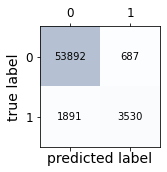

In [134]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confusion, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        ax.text(x=j, y=i,
                s=confusion[i, j],
                va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.tight_layout()
plt.show()

오차 행렬의 대각 행렬은 정확히 분류된 경우이고, 다른 항목은 한 클래스의 샘플들이 다른 클래스로 잘못 분류된 경우가 얼마나 많은지를 알려준다.

이제 이 오차 행렬을 사용하여 앞서 만든 모델들(더미 모델 두 개, 결정 트리, 로지스틱 회귀)을 비교해보겠다.

In [135]:
print("빈도 기반 더미 모델:")
print(confusion_matrix(y_train_5, pred_most_frequent))
print("\n무작위 더미 모델:")
print(confusion_matrix(y_train_5, pred_dummy))
print("\n결정 트리:")
print(confusion_matrix(y_train_5, pred_tree))
print("\nSGD:")
print(confusion_matrix(y_train_5, pred_sgd))

빈도 기반 더미 모델:
[[54579     0]
 [ 5421     0]]

무작위 더미 모델:
[[49613  4966]
 [ 4922   499]]

결정 트리:
[[54207   372]
 [ 3773  1648]]

SGD:
[[53892   687]
 [ 1891  3530]]


오차 행렬을 보면 pred_most_frequent에서 뭔가 잘못된 것이 확실하다. 항상 동일한 클래스를 예측하기 때문이다. 반면에 pred_dummy는 특히 거짓 음성(FN)과 거짓 양성(FP)보다  진짜 양성(TP)이 매우 적고(478), 진짜 양성(TP)보다 거짓 양성(FP)이 매우 많다. 결정 트리의 예측은 더미 분류기보다 정상으로 보이지만, 정확도는 거의 비슷하다. 마지막으로 SGD는 모든 면에서 pred_tree보다 낫다. 진짜 양성(TP)과 진짜 거짓(TN)이 더 많은 반면, 거짓 양성(FP)과 거짓 음성(FN)은 적다. 이렇게 비교하니 결정 트리와 로지스틱 회귀의 결과만 정상이며 로지스틱 회귀가 모든 항목에서 트리 모델보다 잘 작동했다. 그러나 전체 오차 행렬을 조사하기는 솔직히 조금 번거롭다. 이 행렬의 모든 면을 살펴보면 많은 정보를 얻을 수 있지만, 매우 수동적이며 정성적인 방법이다. 다음 절에서 오차 행렬 정보를 요약할 수 있는 여러 방법을 알아보겠다.

## 정확도(Accuracy)

예측 오차<sup>ERR</sup>와 정확도<sup>ACC</sup> 모두 얼마나 많은 샘플을 잘못 분류했는지 일반적인 정보를 알려준다. 오차는 잘못된 예측의 합을 전체 예측 샘플 새로 나눈 것이다. 정확도는 옳은 예측의 합을 전체 예측 샘플 개수로 나누어 계산한다.

$$
ERR = \frac{\text{예측 결과와 실제 값이 다른 건수}}{\text{전체 데이터 수}} = \frac{FP + FN}{FP+FN+TP+TN}
$$

예측 정확도는 오차에서 바로 계산할 수 있다. 

$$
ACC =1 - ERR = \frac{\text{예측 결과와 실제 값이 동일한 건수}}{\text{전체 데이터 수}} = \frac{TN + TP}{FP + FN + TP + TN}
$$

일반적으로 이러한 불균형한 레이블 클래스를 가지는 이진 분류 모델에서는 많은 데이터 중에서 중점적으로 찾아야 하는 매우 적은 수의 결괏값에 Positive를 설정해 1값을 부여하고, 그렇지 않은 경우는 Negative로 0 값을 부여하는 경우가 많다. 예를 들어 사기 행위 예측 모델에서는 사기 행위가 Positive 양성으로 1, 정상 행위가 Negative 음성으로 0 값이 결정 값으로 할당되거나 암 검진 예측 모델에서는 암이 양성일 경우 Positive 양성으로 1, 암이 음성일 경우 Negative 음성으로 0값이 할당되는 경우가 일반적이다.

불균형한 이진 분류 데이터 세트에서는 Positive 데이터 건수가 매우 작기 때문에 데이터에 기반한 머신 러닝 알고리즘은 Positive보다는 Negative로 예측 정확도가 높아지는 경향이 발생한다. 10,000건의 데이터 세트에서 9,900건이 Negative이고 100건이 Positive라면 Negative로 예측하는 경향이 더 강해져서 TN은 매우 커지고 TP는 매우 작아지게 된다. 또한 Negative로 예측할 때 정확도가 높기 때문에 FN(Negative로 예측할 때 틀린 데이터 수)이 매우 작고, Positive로 예측하는 경우가 작기 때문에 FP 역시 매우 작아진다. 결과적으로 정확도 지표는 비대칭한 데이터 세트에서 Positive에 대한 예측 정확도를 판단하지 못한 채 Negative에 대한 예측 정확도만으로도 분류의 정확도가 매우 높게 나타나는 수치적인 판단 오류를 일으키게 된다.

진짜 양성 비율<sup>True Positive Rate, TPR</sup>과 거짓 양성 비율<sup>False Positive Rate, FPR</sup>은 클래스 비율이 다른 경우 유용한 성능 지표다.<sup><a id="a04" href="#p04">[4]</a></sup>

$$
TPR = \frac{TP}{T} = \frac{TP}{FN + TP}
$$

$$
FPR = \frac{FP}{N} = \frac{FP}{FP+TN}
$$

예를 들어 종양 진단 문제에서는 환자가 적절한 치료를 받을 수 있도록 악성 종양을 감지하는 데 관심이 있다. 또 불필요하게 환자에게 걱정을 끼치지 않도록 음성 종양이 악성으로 분류되는 경우(FP)를 줄이는 것이 중요하다. FPR에 비해서 TPR은 전체 양성 샘플(P) 중에서 올바르게 분류된 양성 (또는 관심) 샘플의 비율을 알려 준다.

## 정밀도와 재현율

정밀도<sup>precision</sup>와 재현율<sup>recall</sup>은 Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표다. 앞서 만든 빈도 기반 더미 모델은 Positive로 예측한 TP 값이 하나도 없기 때문에 정밀도와 재현율 값이 모두 0이다.

정밀도와 재현율은 다음과 같은 공식으로 계산된다.

$$
PRE = \frac{TP}{TP + FP}
$$

$$
REC = TPR = \frac{TP}{T} = \frac{TP}{TP + FN}
$$

정밀도는 양성 예측의 정확도다. 즉, 예측을 Positive로 한 대상 중에 예측값과 실제 값이 Positive로 일치한 데이터의 비율을 뜻한다. 공식의 분모인 TP + FP는 예측을 Positive로 한 모든 데이터 건수이며, 공식의 분자인 TP는 예측값과 실제 값이 Positive로 일치한 데이터 건수다. Positive 예측 성능을 더욱 정밀하게 측정하기 위한 평가 지표로 양성 예측도<sup>PPV</sup>라고도 불린다.

재현율은 실제 양성 샘플에서 분류기가 정확하게 감지한 양성 샘플의 비율이다. 즉, 실제 값이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율을 뜻한다. 공식의 분모인 FN + TP는 실제 값이 Positive인 모든 데이터 건수이며 공식의 분자인 TP는 예측과 실제 값이 Positive로 일치한 데이터 건수다. 재현율은 민감도<sup>Sensitivity</sup>, 적중률<sup>hit rate</sup> 또는 진짜 양성 비율<sup>TPR</sup>이라고도 불린다.

사이킷런은 정밀도 계산을 위해 <code>precision_score()</code>를, 재현율 계산을 위해 <code>recall_score()</code>를 API로 제공한다.

In [136]:
from sklearn.metrics import precision_score, recall_score

print('정밀도: {0:.3f}, 재현율: {1:.3f}'.format(precision_score(y_train_5, pred_sgd), 
                                                recall_score(y_train_5, pred_sgd)))

정밀도: 0.837, 재현율: 0.651


<b>그림 2</b> 오차 행렬 예시
<div style="text-align:center;">
    <img src="./images/Evaluation Indicator/오차 행렬 예시.png">
</div>

재현율 최적화와 정밀도 최적화는 상충한다. 모든 샘플을 진짜 음성(TN)이 하나도 없고 모두 양성 클래스에 속한다고 예측하면, 거짓 음성(FN)이 없어져 재현율이 완벽해진다. 하지만 모든 샘플을 양성으로 예측하면 거짓 양성(FP)을 많이 만들고, 따라서 정밀도는 매우 낮아진다. 다른 한편으로 데이터 포인트 하나만 양성이고 나머지는 음성이라고 예측한다면 정밀도는 (진짜 그 데이터 포인트가 양성이라면) 완벽하다. 하지만 재현율은 매우 낮아질 것이다.

정밀도와 재현율 지표 중에 이진 분류 모델의 업무 특성에 따라서 특정 평가 지표가 더 중요한 지표로 간주될 수 있다. <b>재현율이 중요한 지표인 경우는 실제 Positive 양성 데이터를 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우다.</b> 예를 들어 암 판단 모델은 재현율이 훨씬 중요한 지표다. 왜냐햐면 실제 Positive인 암 환자를 Positive 양성이 아닌 Negative 음성으로 잘못 판단했을 경우 오류의 대가가 생명을 앗아갈 정도로 심각하기 때문이다. 반면에 실제 Negative인 건강한 환자를 암 환자인 Positive로 예측한 경우면 다시 한번 재검사를 하는 수준의 비용이 소모될 것이다.

보험 사기와 같은 금융 사기 적발 모델도 재현율이 중요하다. 실제 금융거래 사기인 Positive 건을 Negative로 잘못 판단하게 되면 회사에 미치는 손해가 클 것이다. 반면에 정상 금융거래인 Negative를 금융사기인 Positive로 잘못 판단하더라도 다시 한번 금융 사기인지 재확인하는 절차를 가동하면 된다. 물론 고객에게 금융 사기 혐의를 잘못 씌우면 문제가 될 수 있기에 정밀도도 중요 평가 지표지만, 업무적인 특성을 고려하면 재현율이 상대적으로 더 중요한 지표다.

보통은 재현율이 정밀도보다 상대적으로 중요한 업무가 많지만, 정밀도가 더 중요한 지표인 경우도 있다. 예를 들어 스팸메일 여부를 판단하는 모델의 경우 실제 Positive인 스팸 메일을 Negative인 일반 메일로 분류하더라도 사용자가 불편함을 느끼는 정도이지만, 실제 Negative인 스팸 메일을 Positive인 스팸 메일로 분류할 경우에는 메일을 아예 받지도 못하게 돼 업무에 차질이 생긴다.

<b>업무에 따른 재현율과 정밀도의 상대적 중요도</b>

<ul>
    <li>재현율이 상대적으로 더 중요한 지표인 경우는 실제 Positive 양성인 데이터 예측을 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우: 암 진단, 금융사기 판별</li>
    <li>정밀도가 상대적으로 더 중요한 지표인 경우는 실제 Negative 음성인 데이터 예측을 Positive 양성으로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우: 스팸 메일 판별</li>
</ul>

다시 한번 재현율과 정밀도의 공식을 살펴보면, 재현율 = TP / (TP + FN), 정밀도 = TP / (TP + FP)이다. 재현율과 정밀도 모두 TP를 높이는 데 동일하게 초점을 맞추지만, 재현율은 FN(실제 Positive, 예측 Negative)를 낮추는 데, 정밀도는 FP를 낮추는 데 초점을 맞춘다. 이 같은 특성 때문에 재현율과 정밀도는 서로 보완적인 지표로 분류의 성능을 평가하는 데 적용된다. 가장 좋은 성능 평가는 재현율과 정밀도 모두 높은 수치를 얻는 것이다. 반면에 둘 중 어느 한 평가 지표만 매우 높고, 다른 수치는 매우 낮은 결과를 나타내는 경우는 바람직하지 않다.

## 정밀도/재현율 트레이드오프

SGDClassifier가 분류를 어떻게 결정하는지 살펴보며 이 트레이드오프를 이해해보겠다. 이 분류기는 <b>결정 함수</b><sup>decision function</sup>를 사용하여 각 샘플의 점수를 계산한다. 이 점수가 임곗값보다 크면 샘플을 양성 클래스에 할당하고 그렇지 않으면 음성 클래스에 할당한다. [그림 3]에 가장 낮은 점수부터 가장 높은 점수까지 몇 개의 숫자를 나열했다. <b>결정 임곗값</b><sup>decision threshold</sup>이 가운데 (두 개의 숫자 5 사이) 화살표라고 가정해보겠다. 임곗값 오른쪽에 4개의 진짜 양성(실제 숫자 5)과 하나의 거짓 양성(실제 숫자 6)이 있다. 그렇기 때문에 이 임곗값에서 정밀도는 80%(5개 중 4개)다. 하지만 실제 숫자 5는 6개고 분류기는 4개만 감지했으므로 재현율은 67%(6개 중 4개)다. 이번에 임곗값을 높이면(임곗값을 오른쪽 화살표로 옮기면) 거짓 양성(숫자 6)이 진짜 음성이 되어 정밀도가 높아진다(이 경우에 100%가 된다). 하지만 진짜 양성 하나가 거짓 음성이 되었으므로 재현율이 50%로 줄어든다. 반대로 임곗값을 내리면 재현율이 높아지고 정밀도가 줄어든다.

<b>그림 3</b> 정밀도/재현율 트레이드오프
<div style="text-align:center;">
    <img src="./images/Evaluation Indicator/pr_trade_off.png">
</div>

사이킷런에서 임곗값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인할 수 있다. 분류기의 <code>predict()</code> 메서드 대신 <code>decision_function()</code> 메서드를 호출하면 각 샘플의 점수를 얻을 수 있다. 이 점수를 기반으로 원하는 임곗값을 정해 예측을 만들 수 있다.

In [137]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [138]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

SGDClassifier의 임곗값이 0이므로 위 코드는 <code>predict()</code> 메서드와 같은 결과(즉, True)를 반환한다.<sup><a id="a05" href="#p05">[5]</a></sup> 임곗값을 높여보겠다.

In [139]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

이 결과는 임곗값을 높이면 재현율이 줄어든다는 것을 보여준다. 이미지가 실제로 숫자 5이고 임곗값이 0일 때는 분류기가 이를 감지했지만, 임곗값을 8,000으로 높이며 이를 놓치게 된다.

그렇다면 적절한 임곗값을 어떻게 정할 수 있을까? 이를 위해서는 먼저 <code>cross_val_predict()</code> 함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해야 한다. 하지만 이번에는 예측 결과가 아니라 결정 점수를 반환받도록 지정해야 한다.

In [140]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

이 점수로 <code>precision_recall_curve()</code> 함수를 사용하여 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산할 수 있다.

In [141]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

이제 맷플롯립을 이용해 임곗값의 함수로 정밀도와 재현율을 그릴 수 있다.

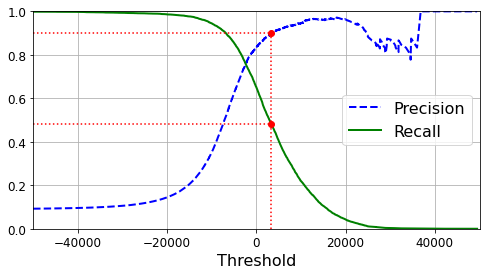

In [165]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])
    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> 위 그림에서 정밀도 곡선이 재현율 곡선보다 왜 더 울퉁불퉁한지 의아할 수 있다. 이는 임곗값을 올리더라도 정밀도가 가끔 낮아질 때가 있기 때문이다(일반적으로는 높아져야 한다). 그 이유를 이해하기 위해 [그림 3]을 다시 살펴보겠다. 가운데 임곗값에서 오른쪽으로 숫자 하나만큼 이동하면 정밀도는 4/5(80%)에서 3/4(75%)로 줄어든다. 반면 재현율은 임곗값이 올라감에 따라 줄어들 수 밖에 없어 부드러운 곡선이 되는 것이다.
    </div>

좋은 정밀도/재현율 트레이드오프를 선택하는 다른 방법은 다음 그림처럼 재현율에 대한 정밀도 곡선을 그리는 것이다(표시된 임곗값은 앞에서와 동일하다).<sup><a id="a06" href="#p06">[6]</a></sup>

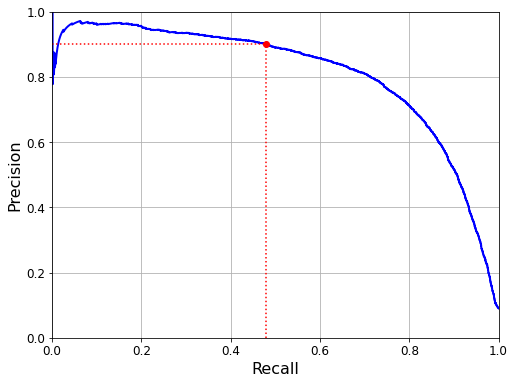

In [169]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

재현율 80% 근처에서 정밀도가 급격하게 줄어들기 시작한다. 이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋다. 예를 들면 재현율이 60% 정도인 지점이다. 물론 이런 선택은 프로젝트에 따라 달라진다.

정밀도 90%를 달성하는 것이 목표라고 가정해보자. 위의 임곗값에 따른 정밀도/재현율 그래프에서 임곗값이 약 8,000 정도라는 것을 알 수 있다. 조금 더 정확하게 최소한 90% 정밀도가 되는 가장 낮은 임곗값을 찾을 수 있다(<code>np.argmax()</code>는 최댓값의 첫 번째 인덱스를 반환하므로 여기서 첫 번째 True 값을 의미한다).

In [170]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

threshold_90_precision

3370.0194991439594

(훈련 세트에 대한) 예측을 만들려면 분류기의 <code>predict()</code> 메서드를 호출하는 대신 다음 코드를 실행한다.

In [171]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

이 예측에 대한 정밀도와 재현율을 확인해보자.

In [176]:
print('정밀도: {0:.3f}, 재현율: {1:.3f}'.format(precision_score(y_train_5, y_train_pred_90), 
                                                recall_score(y_train_5, y_train_pred_90)))

정밀도: 0.900, 재현율: 0.480


정밀도 90%를 달성한 분류기를 만들었다. 여기서 볼 수 있듯이 어떤 가상의 정밀도에 대해서도 분류기를 손쉽게 만들 수 있다. 충분히 큰 임곗값을 지정하면 끝이다.

## 정밀도와 재현율의 맹점

앞에서도 봤듯이 Positive 예측의 임곗값을 변경함에 따라 정밀도와 재현율의 수치가 변경된다. 임곗값의 이러한 변경은 업무 환경에 맞게 두 개의 수치를 상호 보완할 수 있는 수준에서 적용돼야 한다. 그렇지 않고 단순히 하나의 성능 지표 수치를 높이기 위한 수단으로 사용돼서는 안 된다. 다음은 정밀도 또는 재현율 평가 지표 수치 중 하나를 극단적으로 높이는 방법이지만 숫자 놀음에 불과한 방법이다.

### 정밀도가 100% 되는 방법

확실한 기준이 되는 경우만 Positive로 예측하고 나머지는 모두 Negative로 예측한다. 예를 들어 환자가 80세 이상이고 비만이며 이전에 암 진단을 받았고 암 세포의 크기가 상위 0.1% 이상이면 무조건 Positive, 다른 경우는 Negative로 예측하는 것이다.

정밀도 = TP / (TP + FP)이다. 전체 환자 1,000명 중 확실한 Positive 징후만 가진 환자는 단 1명이라고 하면 이 한 명만 Positive로 예측하고 나머지는 모두 Negative로 예측하더라도 FP는 0, TP는 1이 되므로 정밀도는 1 / (1 + 0)으로 100%가 된다.

### 재현율이 100% 되는 방법

모든 환자를 Positive로 예측하면 된다. 재현율 = TP / (TP + FN)이므로 전체 환자 1,000명을 다 Positive로 예측하는 것이다. 이 중 실제 양성인 사람이 30명 정도라도 TN이 수치에 포함되지 않고 FN은 아예 0이므로 30 / (30 + 0)으로 100%가 된다.

이처럼 정밀도와 재현율 성능 수치도 어느 한쪽만 참조하면 극단적인 수치 조작이 가능하다. 따라서 정밀도 또는 재현율 중 하나만 스코어가 좋고 다른 하나는 스코어가 나쁜 분류는 성능이 좋지 않은 분류로 간주할 수 있다. 물론 앞의 예제에서와 같이 분류가 정밀도 또는 재현율 중 하나에 상대적인 중요도를 부여해 각 예측 상황에 맞는 분류 알고리즘을 튜닝할 수 있지만, 그렇다고 정밀도/재현율 중 하나만 강조하는 상황이 돼서는 안 된다(예를 들어, 암 예측 모델에서 재현율을 높인다고 걸핏하면 양성으로 판단할 경우 환자의 부담과 불평이 커지게 된다).

이에 정밀도와 재현율의 수치가 적절하게 조합돼 분류의 종합적인 성능 평가에 사용될 수 있는 평가 지표가 필요하다.

## F-score

f-점수<sup>f-score</sup>는 정밀도와 재현율의 조화 평균<sup>harmonic mean</sup>이다. f-점수는 정밀도와 재현율이 어느 한 쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가진다. 즉, f-점수가 높다는 것은 재현율과 정밀도가 고르게 높다는 뜻이다. f-점수의 공식은 다음과 같다.

$$
F1 = \frac{2}{\frac{1}{REC} + \frac{1}{PRE}} = 2 \times \frac{PRE \times REC}{PRE + REC}
$$

특별히 이 공식을 f<sub>1</sub>-점수라고도 한다.<sup><a id="a07" href="#p07">[7]</a></sup> 만일 A 예측 모델의 경우 정밀도가 0.9, 재현율이 0.1로 극단적인 차이가 나고, B 예측 모델은 정밀도가 0.5, 재현율이 0.5로 정밀도와 재현율의 큰 차이가 없다면 A 예측 모델의 F1 스코어는 0.18이고, B 예측 모델의 F1 스코어는 0.5로 B모델이 A 모델에 비해 매우 우수한 F1 스코어를 가지게 된다.

사이킷런은 F1 스코어를 구하기 위해 <code>f1_score()</code>라는 API를 제공한다. 앞서 계산한 '5와 5 아님' 데이터셋의 예측에 적용해보겠다. 여기서 숫자 '5'가 양성 클래스('5'는 True, 나머지는 False 레이블을 가진다)이므로 양성 클래스가 소수<sup>minority</sup> 클래스다.

In [185]:
from sklearn.metrics import f1_score
print("빈도 기반 더미 모델의 f1 score: {:.2f}".format(
    f1_score(y_train_5, pred_most_frequent)))
print("무작위 더미 모델의 f1 score: {:.2f}".format(
    f1_score(y_train_5, pred_dummy)))
print("트리 모델의 f1 score: {:.2f}".format(
    f1_score(y_train_5, pred_tree)))
print("SGD 모델의 f1 score: {:.2f}".format(
    f1_score(y_train_5, pred_sgd)))

빈도 기반 더미 모델의 f1 score: 0.00
무작위 더미 모델의 f1 score: 0.09
트리 모델의 f1 score: 0.44
SGD 모델의 f1 score: 0.73


여기서 두 가지를 주목해야 한다. 하나는 양성 클래스로 예측된 것이 하나도 없어서 빈도 기반 더미 모델이 에러 메시지를 내뱉는다(F1 스코어의 분모가 0이 된다). 또한 무작위 더미 분류기와 트리 분류기 사이에서도 정확도에는 없던 뚜렷한 차이를 볼 수 있다. F1 스코어를 사용해 평가하면 예측 성능이 다시 하나의 숫자로 요약된다. 하지만 어떤 모델이 좋은지 직관적으로 판단하는 데는 정확도보다 F1 스코어가 낫다. 그러나 F1 스코어는 정확도보다 이해하거나 설명하기 어렵다는 게 단점이다.

<code>classification_report()</code> 함수는 정밀도, 재현율, F1 스코어 모두를 한 번에 계산해서 깔끔하게 출력해준다.

In [186]:
from sklearn.metrics import classification_report
print(classification_report(y_train_5, pred_most_frequent,
                            target_names=["5 아님", "5"]))

              precision    recall  f1-score   support

        5 아님       0.91      1.00      0.95     54579
           5       0.00      0.00      0.00      5421

    accuracy                           0.91     60000
   macro avg       0.45      0.50      0.48     60000
weighted avg       0.83      0.91      0.87     60000



C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<code>classification_report()</code> 함수는 클래스마다 (여기에서는 True와 False) 한 줄씩 출력을 만들고, 각 클래스가 양성일 때 정밀도, 재현율, F1 스코어를 리포트한다. 이전에 소수 클래스인 숫자 '5'를 양성 클래스로 간주했다. 만약 양성 클래스를 '5아님'으로 바꾼다면 <code>classification_report()</code> 출력에서 볼 수 있듯이 most_frequent 모델의 F1 스코어가 0.95다. 더 나아가 모든 샘플을 '5 아님'으로 분류하기 때문에 '5 아님' 클래스의 재현율이 1이다. F1 스코어 오른쪽의 마지막 열은 각 클래스에 대한 지지도<sup>support</sup>로, 단순히 이 클래스에 있는 진짜 샘플의 수다.

분류 리포트의 마지막 세 줄은 정밀도, 재현율, F1 스코어의 평균을 보여준다. macro avg는 단순히 클래스별 점수의 평균을 계산한 것이다. weighted avg는클래스의 샘플 수로 가중 평균한 것이다. 두 클래스를 평균한 것이므로 양성 클래스의 개념이 필요하지 않다. 양성 클래스의 정밀도나 재현율 점수만 보는 것에 비해 두 클래스를 평균하면 숫자 하나로 된 의미 있는 지표를 얻을 수 있다. 무작위 더미 분류기와 SGD의 리포트도 확인해보자.

In [191]:
print(classification_report(y_train_5, pred_dummy,
                            target_names=["5 아님", "5"]))

              precision    recall  f1-score   support

        5 아님       0.91      0.91      0.91     54579
           5       0.09      0.09      0.09      5421

    accuracy                           0.84     60000
   macro avg       0.50      0.50      0.50     60000
weighted avg       0.84      0.84      0.84     60000



In [192]:
print(classification_report(y_train_5, pred_sgd,
                           target_names=["5 아님", "5"]))

              precision    recall  f1-score   support

        5 아님       0.97      0.99      0.98     54579
           5       0.84      0.65      0.73      5421

    accuracy                           0.96     60000
   macro avg       0.90      0.82      0.85     60000
weighted avg       0.95      0.96      0.95     60000



보다시피, 무작위 더미 모델과 가장 좋은 성능의 SGD 모델은 그렇게 확연히 차이 나지 않는다. 어떤 클래스를 양성 클래스로 선택하느냐가 이 평가 지표에 큰 영향을 끼친다. 무작위 더미 모델에서 '5'클래스의 F1 스코어가 0.09이지만 (SGD는 0.73), '5 아님' 클래스는 각각 0.91과 0.98이라서 양쪽 모두 수긍할 만한 결과다. 하지만 모든 숫자를 함께 보면 정확한 판단을 내릴 수 있어 SGD 모델의 우수성을 알 수 있다.

# 미주

<b id="p01">1</b> y는 digits.target의 값이 0~8일 때는 False, 9일 때는 True로 만들어 이 예를 이진 분류의 문제로 바꾸었다. [↩](#a01)

<b id="p02">2</b> DummyClassifier는 실제 모델과 비교하기 위해 간단한 규칙을 지원하는 모델이다. strategy 옵션으로 지정할 수 있는 규칙은 클래스 레이블 비율에 맞게 예측하는 stratified, 가장 많은 레이블을 예측하는 most_frequent 등이 있다. 회귀에서 이에 상응하는 DummyRegressor가 있으며, 지원하는 규칙으로는 (기본값인) 평균값을 예측하는 mean과 중간값을 예측하는 median 등이 있다. [↩](#a02)

<b id="p03">3</b> DummyClassifier의 strategy로 지정한 stratified 방식은 클래스 레이블의 비율과 같은 비율로 예측 결과를 만들지만, 타깃 값 y_test와는 다르므로 정확도는 더 낮아진다. [↩](#a03)

<b id="p04">4</b> TPR과 FPR은 오차 행렬에서 행(실제 클래스)끼리 계산하기 때문에 클래스 비율에 영향을 받지 않는다. [↩](#a04)

<b id="p05">5</b> 사실 <code>predict()</code> 메서드도 <code>decision_function()</code>함수를 사용하여 0보다 큰 경우를 양성으로 예측한다. [↩](#a05)

<b id="p06">6</b> <code>average_precision_score()</code> 함수를 사용하면 정밀도/재현율 곡선의 아래 면적을 계산할 수 있어서 서로 다른 두 모델을 비교하는 데 도움이 된다. [↩](#a06)

<b id="p07">7</b> $f$-점수의 일반화된 가중치 조화 평균 공식은 정밀도를 P, 재현율을 R이라고 할 때, $F = \frac{1}{\alpha\frac{1}{P} + (1 - \alpha)\frac{1}{R}} = \frac{(\beta^2 + 1)PR}{\beta^2P + R}, \beta^2 = \frac{1-\alpha}{\alpha}$이다.<br>
$f_1$은 $\beta = 1$일 때, 즉 정밀도와 재현율의 가중치가 동일한 $\alpha=0.5$일 때 점수를 말한다. $\beta$가 1보다 크면 재현율이 강조되고 1보다 작으면 정밀도가 강조된다. 보통 $f$-점수라 하면 $f_1$-점수를 말한다. [↩](#a07)